Libraries imported

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

Two versions of the csv file were loaded. One for direct use with the neural network and one for experimental purposes

In [2]:
deets = pd.read_table('bee_data.csv', sep=',', header=0)
exp = pd.read_table('bee_data.csv', sep=',', header=0)

This function is used to convert the labels of the health from strings to integers so that it can be catergorised later on.

In [3]:
tar = {}
for i, health in enumerate(deets['health'].unique()):
    tar[i] = health
    deets.replace(health, i, inplace=True)

print(tar)

{0: 'hive being robbed', 1: 'healthy', 2: 'few varrao, hive beetles', 3: 'ant problems', 4: 'missing queen', 5: 'Varroa, Small Hive Beetles'}


Data was explored slightly:
- Number of samples
- Size of each category
- Data format

In [4]:
deets['health'].value_counts().sum()

5172

In [8]:
exp['health'].value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

In [5]:
deets.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,0,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,0,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,0,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,0,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,0,False,worker


In [11]:
from keras.preprocessing import image

def path_to_tensor(path):
    path = 'D:\\bee_imgs\\' + path
    temp_im = image.load_img(path, target_size=(244,244))
    im_array = image.img_to_array(temp_im)
    return np.expand_dims(im_array, axis=0)

def paths_to_tensors(path_list):
    tensor_list = [path_to_tensor(img) for img in path_list]
    return np.vstack(tensor_list)

In [138]:
tar

{0: 'hive being robbed',
 1: 'healthy',
 2: 'few varrao, hive beetles',
 3: 'ant problems',
 4: 'missing queen',
 5: 'Varroa, Small Hive Beetles'}

Take a sample from the bee files column for each health category.

In [7]:
healthy_sample = np.hsplit((deets[deets['health']== 1][['file', 'health']].sample(3000)), 2)
few_varrao_sample = np.hsplit((deets[deets['health']== 2][['file', 'health']].sample(500)), 2)
varroa_sample = np.hsplit((deets[deets['health']== 5][['file', 'health']].sample(400)), 2)
ant_sample = np.hsplit((deets[deets['health']== 3][['file', 'health']].sample(400)),2)
robbed_sample = np.hsplit((deets[deets['health']==0][['file', 'health']].sample(250)), 2)
mqueen_sample = np.hsplit((deets[deets['health']==4][['file', 'health']].sample(25)), 2)

Data was reshaped so that it was all one dimensional

In [8]:
healthy_files, healthy_targets = np.reshape(np.array(healthy_sample[0]), 3000), np.reshape(np.array(healthy_sample[1]), 3000)
few_varrao_files, few_varrao_targets = np.reshape(np.array(few_varrao_sample[0]), 500), np.reshape(np.array(few_varrao_sample[1]), 500)
varroa_files, varroa_targets = np.reshape(np.array(varroa_sample[0]), 400), np.reshape(np.array(varroa_sample[1]), 400)
ant_files, ant_targets = np.reshape(np.array(ant_sample[0]), 400), np.reshape(np.array(ant_sample[1]), 400)
robbed_files, robbed_targets = np.reshape(np.array(robbed_sample[0]), 250), np.reshape(np.array(robbed_sample[1]), 250)
mqueen_files, mqueen_targets = np.reshape(np.array(mqueen_sample[0]), 25), np.reshape(np.array(mqueen_sample[1]), 25)

The seperate files were then combined and split into train, validation and test batches.

In [9]:
from keras.utils import np_utils

bee_files = np.concatenate((healthy_files, few_varrao_files, varroa_files, ant_files, robbed_files, mqueen_files), axis=None)
bee_targets = np.concatenate((healthy_targets, few_varrao_targets, varroa_targets, ant_targets, robbed_targets, mqueen_targets), axis=None)
coded_bee_targets = np_utils.to_categorical(bee_targets, 6)


train_targets, cross_targets, train_files, cross_files = train_test_split(coded_bee_targets, bee_files, test_size=0.2)
val_targets, test_targets, val_files, test_files = train_test_split(cross_targets, cross_files, test_size=0.25)

The files are then imported onto the notebook and converted into tensors

In [12]:
train_tensors = paths_to_tensors(train_files)
test_tensors = paths_to_tensors(test_files)
valid_tensors = paths_to_tensors(val_files)

Design a basic untrained model to be used as the benchmark for the transfer learnt model.

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D


model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='sigmoid'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 244, 244, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 122, 122, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       73856     
__________

In [42]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
from keras.callbacks import ModelCheckpoint

epochs = 3


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_4.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, val_targets),
          epochs=epochs, batch_size=33, callbacks=[checkpointer], verbose=1)

Train on 3660 samples, validate on 686 samples
Epoch 1/3
3660/3660 [==============================] - 269s 74ms/step - loss: 5.4809 - acc: 0.6533 - val_loss: 5.8504 - val_acc: 0.6370

Epoch 00001: val_loss improved from inf to 5.85045, saving model to saved_models/weights.best.from_scratch_4.hdf5
Epoch 2/3
3660/3660 [==============================] - 279s 76ms/step - loss: 5.4872 - acc: 0.6596 - val_loss: 5.8504 - val_acc: 0.6370

Epoch 00002: val_loss did not improve from 5.85045
Epoch 3/3
3660/3660 [==============================] - 281s 77ms/step - loss: 5.4872 - acc: 0.6596 - val_loss: 5.8504 - val_acc: 0.6370

Epoch 00003: val_loss did not improve from 5.85045


In [45]:
model.load_weights('saved_models/weights.best.from_scratch_3.hdf5')

In [46]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 65.0655%


Reload the image files as 32x32 images so that they fit the shape of the cifar-10 images 

In [77]:
def path_to_tensor_cifar(path):
    path = 'bee_imgs\\' + path
    temp_im = image.load_img(path, target_size=(32,32))
    im_array = image.img_to_array(temp_im)
    return np.expand_dims(im_array, axis=0)

def paths_to_tensors(path_list):
    tensor_list = [path_to_tensor_cifar(img) for img in path_list]
    return np.vstack(tensor_list)

def path_to_tensor_cifar_public(path):
    temp_im = image.load_img(path, target_size=(32,32))
    im_array = image.img_to_array(temp_im)
    return np.expand_dims(im_array, axis=0)

In [78]:
transfer_train_tensors = paths_to_tensors(train_files)
transfer_test_tensors = paths_to_tensors(test_files)
transfer_valid_tensors = paths_to_tensors(val_files)

In [96]:
transfer_model = Sequential()

transfer_model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=transfer_train_tensors[0].shape))
transfer_model.add(MaxPooling2D(pool_size=2))
transfer_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(MaxPooling2D(pool_size=2))
transfer_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(MaxPooling2D(pool_size=2))
transfer_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
transfer_model.add(MaxPooling2D(pool_size=2))
transfer_model.add(Dropout(0.2))
transfer_model.add(Flatten())
transfer_model.add(Dense(10, activation='relu'))

# load the pre-trained weights onto the model
transfer_model.load_weights('saved_models/weights.best.cifar_7.hdf5')

transfer_model.add(Dense(6, activation='softmax'))

transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 8, 8, 64)          18496     
__________

In [97]:
transfer_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
from keras.callbacks import ModelCheckpoint

epochs = 10


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_4.hdf5', 
                               verbose=1, save_best_only=True)

transfer_model.fit(transfer_train_tensors, train_targets, 
          validation_data=(transfer_valid_tensors, val_targets),
          epochs=epochs, batch_size=33, callbacks=[checkpointer], verbose=1)

Train on 3660 samples, validate on 686 samples
Epoch 1/10
3660/3660 [==============================] - 68s 19ms/step - loss: 1.7359 - acc: 0.6478 - val_loss: 1.6841 - val_acc: 0.6662

Epoch 00001: val_loss improved from inf to 1.68412, saving model to saved_models/weights.best.transfer_4.hdf5
Epoch 2/10
3660/3660 [==============================] - 64s 17ms/step - loss: 1.6410 - acc: 0.6536 - val_loss: 1.5917 - val_acc: 0.6662

Epoch 00002: val_loss improved from 1.68412 to 1.59167, saving model to saved_models/weights.best.transfer_4.hdf5
Epoch 3/10
3660/3660 [==============================] - 63s 17ms/step - loss: 1.5553 - acc: 0.6536 - val_loss: 1.5075 - val_acc: 0.6662

Epoch 00003: val_loss improved from 1.59167 to 1.50749, saving model to saved_models/weights.best.transfer_4.hdf5
Epoch 4/10
3660/3660 [==============================] - 62s 17ms/step - loss: 1.4774 - acc: 0.6536 - val_loss: 1.4320 - val_acc: 0.6662

Epoch 00004: val_loss improved from 1.50749 to 1.43203, saving mode

This is the accuracy of the same model without transfer learning applied.

In [36]:
predictions = [np.argmax(transfer_model.predict(np.expand_dims(feature, axis=0))) for feature in transfer_test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 87.3362%


This is the accuracy with transfer learning applied

In [99]:
predictions = [np.argmax(transfer_model.predict(np.expand_dims(feature, axis=0))) for feature in transfer_test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 65.9389%


A function to use the trained network weights to predict the health state of the bee hive

In [55]:
def bee_predictor(path):
    transfer_model.load_weights('saved_models/weights.best.transfer_1.hdf5')
    temp_tensor = path_to_tensor_cifar_public(path)
    predicted_health = transfer_model.predict(temp_tensor)
    im = mpimg.imread(path)
    plt.imshow(im)
    plt.show()
    return 'This bee is likely to be ' + tar[np.argmax(predicted_health)]

Now the success of the model can be visualised

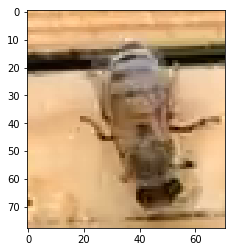

'This bee is likely to be ant problems'

In [69]:
bee_predictor('bee_imgs/030_204.png')

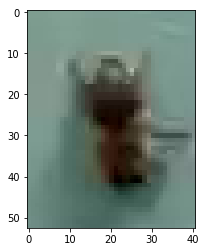

'This bee is likely to be Varroa, Small Hive Beetles'

In [72]:
bee_predictor('bee_imgs/038_362.png')

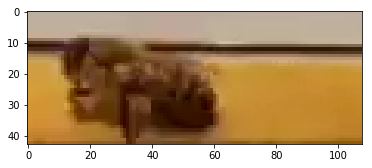

'This bee is likely to be healthy'

In [73]:
bee_predictor('bee_imgs/004_411.png')

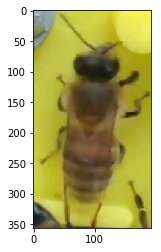

'This bee is likely to be missing queen'

In [75]:
bee_predictor('bee_imgs/034_032.png')

An untrained version of the transfer learning model was trained on the data just for experimentation and this model outpreformed all of the models developed in this project.

In [116]:
transfer_model2 = Sequential()

transfer_model2.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=transfer_train_tensors[0].shape))
transfer_model2.add(MaxPooling2D(pool_size=2))
transfer_model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(MaxPooling2D(pool_size=2))
transfer_model2.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(MaxPooling2D(pool_size=2))
transfer_model2.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
transfer_model2.add(MaxPooling2D(pool_size=2))
transfer_model2.add(Dropout(0.2))
transfer_model2.add(Flatten())
transfer_model2.add(Dense(6, activation='softmax'))

transfer_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 8, 8, 64)          18496     
__________

In [117]:
transfer_model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
epochs = 10


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_untrained_2.hdf5', 
                               verbose=1, save_best_only=True)

transfer_model2.fit(transfer_train_tensors, train_targets, 
          validation_data=(transfer_valid_tensors, val_targets),
          epochs=epochs, batch_size=33, callbacks=[checkpointer], verbose=1)

Train on 3660 samples, validate on 686 samples
Epoch 1/10
3660/3660 [==============================] - 35s 10ms/step - loss: 1.2917 - acc: 0.6426 - val_loss: 0.8067 - val_acc: 0.7070

Epoch 00001: val_loss improved from inf to 0.80669, saving model to saved_models/weights.best.transfer_untrained_2.hdf5
Epoch 2/10
3660/3660 [==============================] - 31s 9ms/step - loss: 0.7348 - acc: 0.7287 - val_loss: 0.5671 - val_acc: 0.7784

Epoch 00002: val_loss improved from 0.80669 to 0.56709, saving model to saved_models/weights.best.transfer_untrained_2.hdf5
Epoch 3/10
3660/3660 [==============================] - 31s 8ms/step - loss: 0.5458 - acc: 0.7937 - val_loss: 0.3847 - val_acc: 0.8455

Epoch 00003: val_loss improved from 0.56709 to 0.38471, saving model to saved_models/weights.best.transfer_untrained_2.hdf5
Epoch 4/10
3660/3660 [==============================] - 31s 8ms/step - loss: 0.4216 - acc: 0.8287 - val_loss: 0.8376 - val_acc: 0.7697

Epoch 00004: val_loss did not improve fr

With an accuracy of 93%, clearly the models developed by the industry leaders are a result of rigorous testing and experimentation.

In [119]:
predictions = [np.argmax(transfer_model2.predict(np.expand_dims(feature, axis=0))) for feature in transfer_test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 93.0131%
